<a href="https://colab.research.google.com/github/DavoodSZ1993/pytorch_tutorial/blob/master/06__GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: davoodsoleymanzadeh
Your Kaggle Key: ··········


100%|██████████| 395M/395M [00:02<00:00, 196MB/s]


In [3]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [4]:
print(os.listdir(DATA_DIR+'/images')[:10])

['7651_2004.jpg', '62872_2019.jpg', '19998_2007.jpg', '56433_2017.jpg', '30652_2010.jpg', '5917_2003.jpg', '27191_2009.jpg', '47405_2014.jpg', '57330_2017.jpg', '28917_2010.jpg']


In [5]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [6]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [7]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [8]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def denorm(img_tensors):
  return img_tensors * stats[1][0] + stats[0][0]

In [10]:
def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break


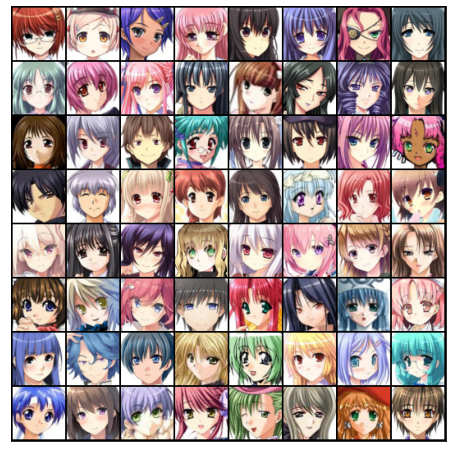

In [11]:
show_batch(train_dl)

In [12]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)

#Discriminator Network

In [15]:
import torch.nn as nn

In [16]:
discriminator = nn.Sequential(
    
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid())

In [17]:
discriminator = to_device(discriminator, device)

#Generator Network

In [18]:
latent_size = 128

In [21]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0,bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1,bias=False),
    nn.Tanh())

torch.Size([128, 3, 64, 64])


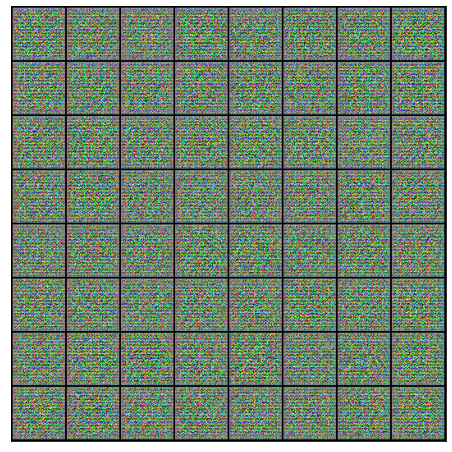

In [22]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [35]:
generator = to_device(generator, device)

In [36]:
def train_discriminator(real_images, opt_d):
  opt_d.zero_grad()

  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1, device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score

In [37]:
def train_generator(opt_g):
  opt_g.zero_grad()

  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  preds = discriminator(fake_images)
  targets = torch.ones(batch_size, 1, device=device)
  loss = F.binary_cross_entropy(preds, targets)

  loss.backward()
  opt_g.step()

  return loss.item()

In [38]:
from torchvision.utils import save_image

In [26]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [39]:
def save_samples(index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
  print('Saving', fake_fname)
  if show:
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1,2,0))

In [40]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


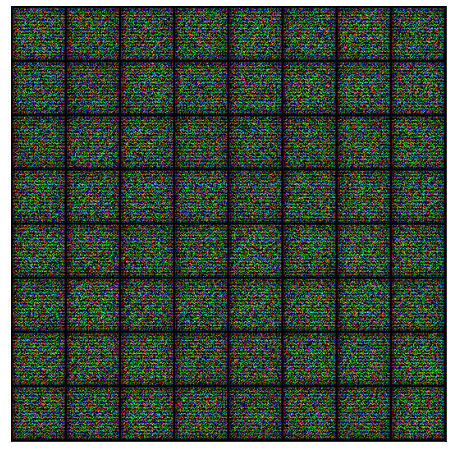

In [41]:
save_samples(0, fixed_latent)